In [44]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import scipy.io as io
import sklearn.metrics as metrics
import copy
plt.rcParams["figure.figsize"] = (20,12)
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")


In [45]:
# loading images
train_img1 = [cv2.imread(file) for file in glob.glob('./inputs/P5/dataset/train/images/*')]
train_label = [io.loadmat(file)['mask']  for file in glob.glob('./inputs/P5/dataset/train/masks/*')]
test_img1  = [cv2.imread(file) for file in glob.glob('./inputs/P5/dataset/test/images/*')]
test_label=[io.loadmat(file)['mask'] for file in glob.glob('./inputs/P5/dataset/test/masks/*')]

In [46]:
train_img = copy.deepcopy(train_img1)
test_img  = copy.deepcopy(test_img1)
for i in range(len(train_img1)):
        for row in range(train_img1[i].shape[0]):
            for col in range(train_img1[i].shape[1]):
                for color in range(3):
                    if color==0:
                        train_img[i][row][col][0] = train_img1[i][row][col][0]/(train_img1[i][row][col][0]+train_img1[i][row][col][1]+train_img1[i][row][col][2])
                    elif color==1:
                        train_img[i][row][col][1] = train_img1[i][row][col][1]/(train_img1[i][row][col][0]+train_img1[i][row][col][1]+train_img1[i][row][col][2])
                    else:
                        train_img[i][row][col][2] = train_img1[i][row][col][2]/(train_img1[i][row][col][0]+train_img1[i][row][col][1]+train_img1[i][row][col][2])

In [47]:
len(train_img),len(train_label),len(test_img),len(test_label)

(50, 50, 3, 3)

In [48]:
train_img[0].shape,train_label[0].shape,test_img[0].shape,test_label[0].shape

((295, 450, 3), (295, 450), (480, 720, 3), (480, 720))

In [49]:
# Calculating Prior prob
P_face = 0
P_non_face = 0

face_pix = []
non_face_pix = []

for i in range(len(train_label)):
    for _ in range(train_label[i].shape[0]):
        for __ in range(train_label[i].shape[1]):
            if train_label[i][_][__] == 1 :
                P_face += 1
                face_pix.append(train_img[i][_][__])
            else:
                P_non_face +=1
                non_face_pix.append(train_img[i][_][__])
                
P_face,P_non_face =  P_face/(P_face+P_non_face), P_non_face/(P_face+P_non_face)    


In [ ]:
print("Prior prob for face class:",P_face)
print("Prior prob for non-face class:",P_non_face)

# Mean calculation
non_face_mean = np.mean(non_face_pix)
face_mean = np.mean(face_pix)

# Variance calculation
non_face_var = np.var(non_face_pix)
face_var = np.var(face_pix)

print("\nMean for face class:",face_mean)
print("Mean for non-face class:",non_face_mean)

print("\nVariance for face class:",face_var)
print("Variance for non-face class:",non_face_var)

Prior prob for skin class: 0.22194392442521707
Prior prob for non-skin class: 0.778056075574783

Mean for skin class: 2.2711952994699334
Mean for non-skin class: 1.5367366925993378

Variance for skin class: 98.82168920564521
Variance for non-skin class: 61.04776912208313


In [ ]:
# multivariate normal pdf function to calculate prob of each pixel
face_pdf = stats.multivariate_normal(face_mean,face_var)
non_face_pdf = stats.multivariate_normal(non_face_mean,non_face_var)

# Bayes face Classifier
def BayesfaceClassifier(images,cost):
    plot_index = 1
    result=[]
    threshold = P_non_face/P_face
    for img in images:
        img2=np.empty((img.shape[0],img.shape[1]),dtype=np.uint8)
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                pix = np.mean(img[row][col])
                
                prob_face = face_pdf.pdf(pix)
                prob_non_face = non_face_pdf.pdf(pix)
                
                if prob_face/prob_non_face > threshold/cost:
                    img2[row][col] = 1
                else:
                    img2[row][col] = 0
                
        plt.subplot(int(len(images)/2)+1,2,plot_index)
        plt.imshow(img2,cmap='gray')
        plot_index += 1
        result.append(img2)
    plt.show()
    return result

pred_label=BayesfaceClassifier(test_img,1e-7)

In [64]:
cm=(metrics.confusion_matrix(test_label[0].flatten(),pred_label[0].flatten())+metrics.confusion_matrix(test_label[1].flatten(),pred_label[1].flatten())+metrics.confusion_matrix(test_label[2].flatten(),pred_label[2].flatten()))/3
total = cm[0][0]+cm[1][1]+cm[1][0]+cm[0][1]
error = round((cm[1][0]+cm[0][1])/total*100,2)
print("Error rate is {}%".format(error))

Error rate is 35.04%


In [65]:
cm=(metrics.confusion_matrix(test_label[0].flatten(),pred_label[0].flatten())+metrics.confusion_matrix(test_label[1].flatten(),pred_label[1].flatten())+metrics.confusion_matrix(test_label[2].flatten(),pred_label[2].flatten()))/3

<AxesSubplot:>

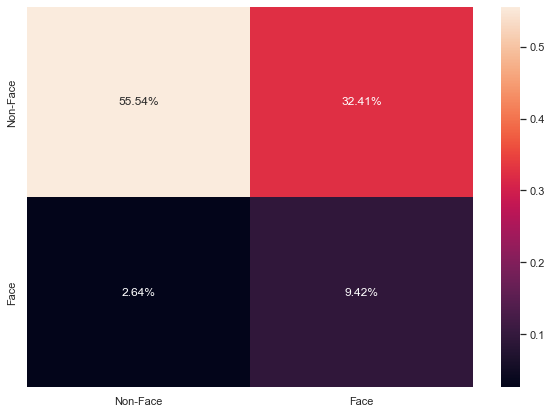

In [66]:
cm = cm.astype('float') / total
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='.2%',xticklabels=['Non-Face','Face'],yticklabels=['Non-Face','Face'])

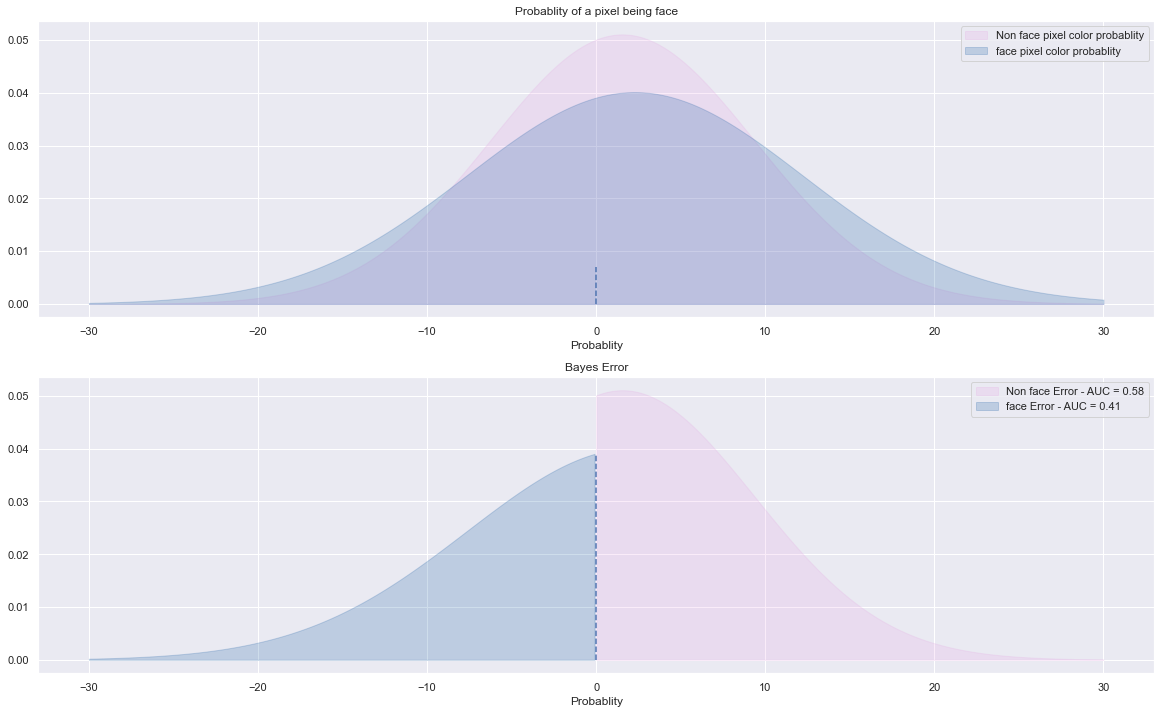

In [ ]:
#Plotting probablity of classes
face_pdf = stats.multivariate_normal(face_mean,face_var)
non_face_pdf = stats.multivariate_normal(non_face_mean,non_face_var)
PlotRange = np.arange(0-30,30.1,0.1)
face_plot = [face_pdf.pdf(x) for x in PlotRange]
non_face_plot = [non_face_pdf.pdf(x) for x in PlotRange]

Threshold = 0
for i in range(len(face_plot)):
    if face_plot[i] >=non_face_plot[i]:
        Threshold = i/10
        break

plt.subplot(2,1,1)
plt.plot([Threshold,Threshold],[0,0.007],'--')
plt.fill_between(PlotRange, non_face_plot, color='#e6a3e3', alpha=0.2,label="Non face pixel color probablity")
plt.fill_between(PlotRange, face_plot, color='#0b559f', alpha=0.2,label="face pixel color probablity")
plt.title("Probablity of a pixel being face")
plt.xlabel("Pixel  | 0-30")
plt.xlabel("Probablity")
plt.legend()


plt.subplot(2,1,2)
PlotRange_Non_face = np.arange(-30,Threshold,0.1)
PlotRange_face = np.arange(Threshold,30.1,0.1)

face_plot = [face_pdf.pdf(x) for x in PlotRange_Non_face]
non_face_plot = [non_face_pdf.pdf(x) for x in PlotRange_face]

auc_non_face = round(metrics.auc(PlotRange_face, non_face_plot),2)
auc_face = round(metrics.auc(PlotRange_Non_face, face_plot),2)

plt.plot([Threshold,Threshold],[0,max(face_plot)],'--')
plt.fill_between(PlotRange_face, non_face_plot, color='#e6a3e3', alpha=0.2,label="Non face Error - AUC = {0}".format(auc_non_face))
plt.fill_between(PlotRange_Non_face, face_plot, color='#0b559f', alpha=0.2,label="face Error - AUC = {0}".format(auc_face))
plt.title("Bayes Error")
plt.xlabel("Pixel brightness | 0-255")
plt.xlabel("Probablity")
plt.legend()

# plt.show()

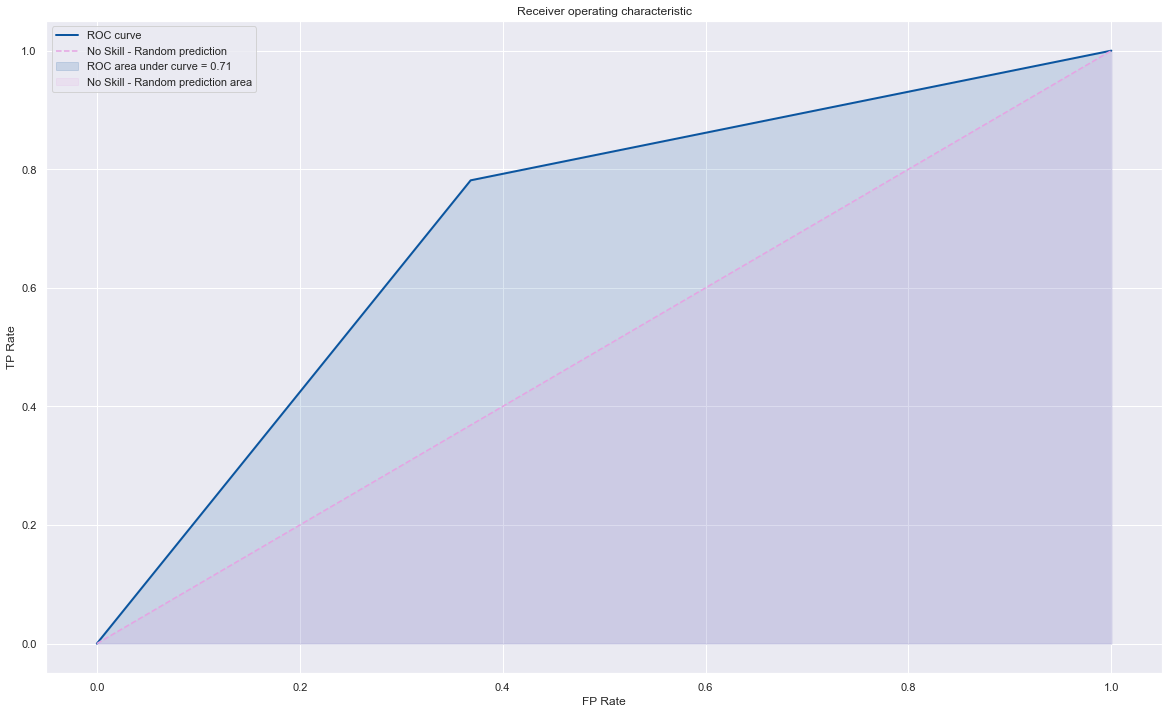

In [ ]:
PredictedLabel = []
Groundtruth = []
for i in range(len(pred_label)):
    for row in range(pred_label[i].shape[0]):
        for col in range(pred_label[i].shape[1]):
            PredictedLabel.append(pred_label[i][row][col])
            Groundtruth.append(test_label[i][row][col])
fpr, tpr, thresholds = metrics.roc_curve(Groundtruth, PredictedLabel, pos_label=1)
plt.plot(fpr, tpr,color='#0b559f', label='ROC curve',lw=2)
plt.fill_between(fpr, tpr, color='#0b559f', alpha=0.15,label='ROC area under curve = {0}'.format(round(metrics.auc(fpr, tpr),2)))
plt.plot([0,1], [0,1],'--',color='#e6a3e3', label='No Skill - Random prediction')
plt.fill_between([0,1], [0,1], color='#e6a3e3', alpha=0.15,label='No Skill - Random prediction area')

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.show()